<font color = "black">This project's inspiration comes from Aurélien Géron's book : Hands-On Machine Learning with Scikit-Learn and TensorFlow. </font>

<font color = "black"> This project uses episodic batch/off-policy semi-gradient for state-action approximation.</font>

<!-- <img src="pictures/myimage.JPG" width="600"/> -->

In [13]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import gym

from collections import deque
from copy import deepcopy

In [14]:
env = gym.make("CartPole-v1") #("Pendulum-v0")

Reward
Reward is 1 for every step taken, including the termination step. The threshold is 475 for v1.

Starting State
    All observations are assigned a uniform random value between ±0.05.

Episode Termination

    Pole Angle is more than ±12°
    
    Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)

    Episode length is greater than 200 (500 for v1).

In [15]:
# space (0 => Push cart to the left, 1 => Push cart to the right), (cart pos, cart veloc, pole angle, pole veloc)
env.action_space, env.observation_space

(Discrete(2),
 Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32))

In [16]:
class model(nn.Module):
    def __init__(self, input_units = 4, h_units = 32, out_units = 2):
        super().__init__()
        self.l = nn.Sequential(
            nn.Linear(input_units, h_units),
            nn.ELU(),
            nn.Linear(h_units, h_units),
            nn.ELU(),
            nn.Linear(h_units, out_units)
        )
        self.initialize_weights()
    def forward(self, x):
        x = self.l(x)
        return x
    
    # weight init my improve convergence speed
    def initialize_weights(self):
        for idx, m in enumerate(self.modules()): # will return modules and submodules
            if(isinstance(m, (nn.Linear))):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.zero_()

In [17]:
class Agent:
  def __init__(self):
    self.replay_memory = deque(maxlen=2000)
    self.network = model()
    self.state_dict = deepcopy(self.network.state_dict())

    self.lr = 0.01
    self.discount_rate = 0.95
    self.path = "best_model.pt"
    self.dist_constaint = 1 # this is an additional constraint, if the distance from the middle is > 1 inches, terminates.

    self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.lr)
    self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.999)
    self.Loss = nn.MSELoss()

    self.batch_size = 32

  def greedy(self, state):
    if(np.random.rand() < epsilon):
        action = np.random.randint(2)
    else:
        action = torch.argmax(self.network(torch.tensor(state, dtype = torch.float32)))
    return int(action)

  def train_batch(self):
    states, actions, rewards, next_states, dones = self.sample_sarsa()
    q_values = self.network(torch.tensor(states, dtype = torch.float32))
    rewards = torch.tensor(rewards, dtype = torch.float32)[:, None]
    self.optimizer.zero_grad()
    next_q_vals = self.network(torch.tensor(next_states, dtype = torch.float32))

    next_mask = next_q_vals.argmax(1)[:, None]
    mask = torch.tensor(actions)[:, None]
    dones = torch.tensor(dones, dtype = torch.int32)[:, None]
    target = rewards + self.discount_rate * (1 - dones) * next_q_vals.gather(1, next_mask)
    loss = self.Loss(target, q_values.gather(1, mask))
    loss.backward()
    self.optimizer.step()
    self.scheduler.step()

  def sample_sarsa(self):
    indices = np.random.randint(0, len(self.replay_memory), size = self.batch_size)
    states, actions, rewards, next_states, dones = [[self.replay_memory[i][j] for i in indices] 
                                                                        for j in range(5)]
    return states, actions, rewards, next_states, dones
  
  def action_step(self, state, action):
    next_state, reward, done, info = env.step(int(action))
    if(abs(next_state[0]) > self.dist_constaint):
        done = True
    self.replay_memory.append((state, action, reward, next_state, done))
    return next_state, done

In [18]:
env.seed()
np.random.seed()

agent = Agent()

rewards_list = []
win_len = 50
n_episodes = 3000

mx = 0
for i in range(n_episodes):
    it = 0
    state = env.reset()
    action = np.random.randint(0, 2)
    for j in range(1000):
        epsilon = max(1 - i/500, 0.01)
        state, done = agent.action_step(state, action)
        action = agent.greedy(state)
        it += 1
        if(done):
            break

    rewards_list.append(it)
    if(i > 50):
        agent.train_batch()
    mean_reward = sum(rewards_list[-win_len:])/min(len(rewards_list), win_len)
    if(mean_reward > mx):
        mx = mean_reward
        state_dict = deepcopy(agent.network.state_dict())
        
    print("\rEpisode : {} eps : {:.3f}  Step : {} Mean Reward {:.3f} ".format(i, epsilon, it, mean_reward), end = "")

Episode : 2999 eps : 0.010  Step : 500 Mean Reward 430.060 

In [19]:
def average_window(data, win_size):
    res = []
    for i in range(len(data) - win_size + 1):
        s = 0
        for j in range(i, i + win_size):
            s += data[j]
        res.append(s/win_size)
    return res

In [20]:
avg = average_window(rewards_list, win_len)

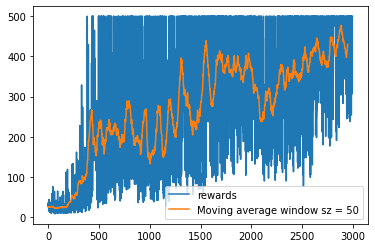

In [21]:
plt.plot(rewards_list, label = "rewards")
plt.plot(avg, label = "Moving average window sz = " + str(win_len))
plt.legend()

In [ ]:
obs = env.reset()
    
done = False
total_rewards = 0
np.random.seed()
agent.network2.load_state_dict(state_dict)

for i in range(10):
    obs, reward, done, info = env.step(env.action_space.sample())

with torch.no_grad():
    while(not done):
        action = int(torch.argmax(agent.network2(torch.tensor(obs, dtype = torch.float32))))
        obs, reward, done, info = env.step(action)
        total_rewards += reward
        env.render()
        
env.close()
print(total_rewards)

490.0
